In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
%matplotlib  widget

In [4]:
# igramsDir is where the cropped, unwrapped igrams are 
igramsDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-2 # skip1 pairs
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')
# loop through the dates 
for i in range(numIgrams): # numIgrams if doing all of them at once
    date1=dates[i]
    date2=dates[i+2] # skip1
    igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
print('unfiltered unwrapped skip1 igrams loaded.')

unfiltered unwrapped igrams loaded.


In [5]:
# Read in 2day precipitation data
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')
#precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_cumulative.txt', dtype='float')

# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# take numIgrams and pull out the igram_dates, corresponding to the first day of each igram
igram_dates = slc_dates[1::]


# BIGGER STORMS
# days with precip > 0.3cm 
#print('i \tdate \t\t       precip > 0.3cm')
print('i \tdate \t\t       precip > 0.0cm')
rain_dates = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.0:
        print(str(i)+'\t'+str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])

i 	date 		       precip > 0.0cm
0	2017-05-10 00:00:00    0.33020000000000005 cm
47	2018-12-07 00:00:00    5.0546 cm
55	2019-03-13 00:00:00    0.0762 cm
59	2019-05-12 00:00:00    0.10160000000000001 cm
74	2019-09-27 00:00:00    1.4478 cm
83	2019-11-20 00:00:00    2.286 cm
86	2019-12-08 00:00:00    0.254 cm
97	2020-02-12 00:00:00    1.1684 cm
102	2020-03-13 00:00:00    0.40640000000000004 cm
103	2020-03-19 00:00:00    0.254 cm
107	2020-04-12 00:00:00    0.9906 cm
154	2021-01-25 00:00:00    0.0762 cm
186	2021-08-11 00:00:00    0.381 cm


Load reference pixels.

In [6]:
# load reference pixels mask 
maskFile = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

Reference pixel mask loaded.


Old: reference to box of pixels.

In [7]:
%%script echo skipping
# reference to box
# correct all igrams so there's a zero/stationary point 
unwr_full_res_cor_2 = np.ndarray(np.shape(unwr_full_res),dtype='float') # this is two reference to a smaller region and compare 
for i in range(numIgrams):
    # remove the average phase from small reference region at foot of mountains   
    unwr_full_res_cor_2[i] = unwr_full_res[i]-np.mean(unwr_full_res[i,150:180,800:900])
print('igrams corrected by subtracting avg value over small reference region in mountains.')

igrams corrected by subtracting avg value over small reference region in mountains.


Reference all igrams to reference pixels loaded above.

In [8]:
# correct all igrams so there's a zero/stationary point 
# initialize an array for corrected igrams
unwr_full_res_cor = np.ndarray(np.shape(unwr_full_res),dtype='float')
for i in range(numIgrams):
    unwr_full_res_cor[i] = unwr_full_res[i]-np.mean(unwr_full_res[i,mask_y,mask_x])
print('igrams corrected by subtracting avg value of reference pixels chosen with 4 criteria.')
# if need to save RAM space, delete the original igrams here.
del unwr_full_res

igrams corrected by subtracting avg value of reference pixels chosen with 4 criteria.


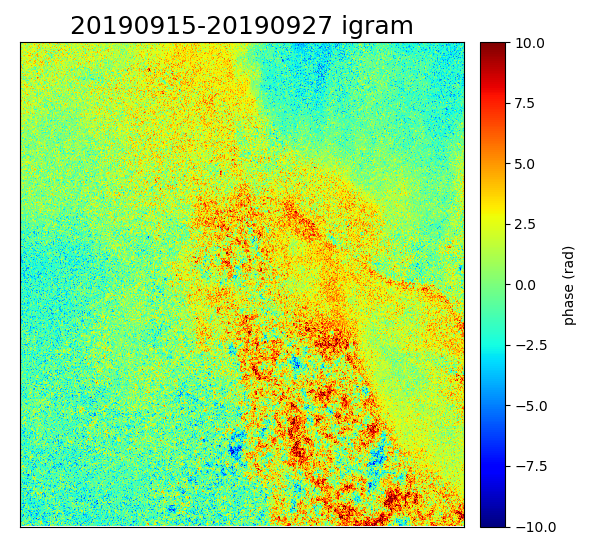

In [14]:
# sample igrams for Geol.Sci.Seminar 3-17-23
# for seminar: k=45,46,47,49

min_test=-10
max_test=10

k = 72
date1 = dates[k]; date2 = dates[k+2]
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(unwr_full_res_cor[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=min_test,vmax=max_test)
#plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=-3,vmax=4)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
#plt.xlabel('range'); plt.ylabel('azimuth')
plt.title(str(date1)+'-'+str(date2)+' igram',fontsize=18) 
#plt.title('\"unfiltered, unwrapped igram\"')
plt.show()